In [29]:
import warnings
import pickle
import shap

from IPython.display import Markdown, display
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [30]:
!pwd

/mnt/x/1_projects/dsi/scaling_to_production/02_activities/assignments


In [31]:
import pandas as pd
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', skiprows=1, header = 0, names = columns))
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
1,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
2,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
3,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
4,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0


In [32]:
num_columns = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']
cat_columns = ['month', 'day']

fires_dt[num_columns] = fires_dt[num_columns].apply(pd.to_numeric, errors='coerce')
pd.DataFrame(fires_dt.dtypes, columns=["Type"]).style.set_caption("<h3>Column Types")

,Type
coord_x,int64
coord_y,int64
month,object
day,object
ffmc,float64
dmc,float64
dc,float64
isi,float64
temp,float64
rh,int64


# Get X and Y

Create the features data frame and target data.

In [33]:
X = fires_dt.iloc[:, :-1]
y = fires_dt.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

Markdown(
    f"- Feature shape *X*: **{X.shape}**\n"
    f"- Target shape *y*: **{y.shape}**"
    )
X.head()
y.head()

,area
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [34]:
num_columns.copy().pop()

'area'

In [35]:
# preproc1
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,  MinMaxScaler, StandardScaler, RobustScaler

preproc1 = ColumnTransformer([
    ('num_transformer', MinMaxScaler(), ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']),
    ('col_transformer', OneHotEncoder(handle_unknown='ignore'), ['month', 'day']),
])

preproc1

ColumnTransformer(transformers=[('num_transformer', MinMaxScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('col_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [36]:
# preproc2

preproc2 = ColumnTransformer([
    ('num_transformer', StandardScaler(), ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']),
    ('col_transformer', OneHotEncoder(handle_unknown='ignore'), ['month', 'day']),
])

preproc2

ColumnTransformer(transformers=[('num_transformer', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('col_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [37]:
# Pipeline A = preproc1 + baseline

base_regressor = LinearRegression()
pipeline_A = Pipeline([
    ('preproc', preproc1),
    ('regressor', base_regressor)
])
pipeline_A

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('col_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [38]:
# Pipeline B = preproc2 + baseline

pipeline_B = Pipeline([
    ('preproc', preproc2),
    ('regressor', base_regressor)
])
pipeline_B

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('col_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [39]:
# Pipeline C = preproc1 + advanced model

# alternative_regressor = LogisticRegression()
alternative_regressor = RandomForestRegressor()

pipeline_C = Pipeline([
    ('preproc', preproc1),
    ('regressor', alternative_regressor)
])
pipeline_C

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('col_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [40]:
# Pipeline D = preproc2 + advanced model

pipeline_D = Pipeline([
    ('preproc', preproc2),
    ('regressor', alternative_regressor)
])
pipeline_D

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('col_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [41]:
param_grid_A = {
    'regressor__fit_intercept': [False, True],
    'regressor__positive': [False, True],
    'regressor__copy_X': [True, False],
}

grid_search_1 = GridSearchCV(estimator=pipeline_A, param_grid=param_grid_A, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
gs1 = grid_search_1.fit(X_train, y_train)
Markdown(f"### Pipeline A\n**Best score:** {gs1.best_score_}  \n**Best params:** {gs1.best_params_}")

### Pipeline A
**Best score:** -1935.0094118055895  
**Best params:** {'regressor__copy_X': True, 'regressor__fit_intercept': False, 'regressor__positive': True}

In [42]:
grid_search_2 = GridSearchCV(estimator=pipeline_B, param_grid=param_grid_A, cv=5, scoring='neg_mean_squared_error', verbose=True)
gs2 = grid_search_2.fit(X_train, y_train)
Markdown(f"### Pipeline B\n**Best score:** {gs2.best_score_}  \n**Best params:** {gs2.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


### Pipeline B
**Best score:** -1950.1130680335787  
**Best params:** {'regressor__copy_X': True, 'regressor__fit_intercept': False, 'regressor__positive': True}

In [43]:
param_grid_B = {
    'regressor__bootstrap': [True, False],
    'regressor__max_depth': [2, 4, 6],
}

grid_search_3 = GridSearchCV(estimator=pipeline_C, param_grid=param_grid_B, cv=5, scoring='neg_mean_squared_error', verbose=True)
gs3 = grid_search_3.fit(X_train, y_train)
Markdown(f"### Pipeline C\n**Best score:** {gs3.best_score_}  \n**Best params:** {gs3.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Pipeline C
**Best score:** -2433.207801999282  
**Best params:** {'regressor__bootstrap': True, 'regressor__max_depth': 4}

In [44]:

grid_search_4 = GridSearchCV(estimator=pipeline_D, param_grid=param_grid_B, cv=5, scoring='neg_mean_squared_error', verbose=True)
gs4 = grid_search_4.fit(X_train, y_train)
Markdown(f"### Pipeline D\n**Best score:** {gs4.best_score_}  \n**Best params:** {gs4.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Pipeline D
**Best score:** -2572.4524180698063  
**Best params:** {'regressor__bootstrap': True, 'regressor__max_depth': 6}

# Evaluate

+ Which model has the best performance?

Here, it seems a Linear Regression is a better option on both pipelines.

# Export

+ Save the best performing model to a pickle file.

In [45]:
with open('pipeline_A.pkl', 'wb') as file:
    pickle.dump(pipeline_A, file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

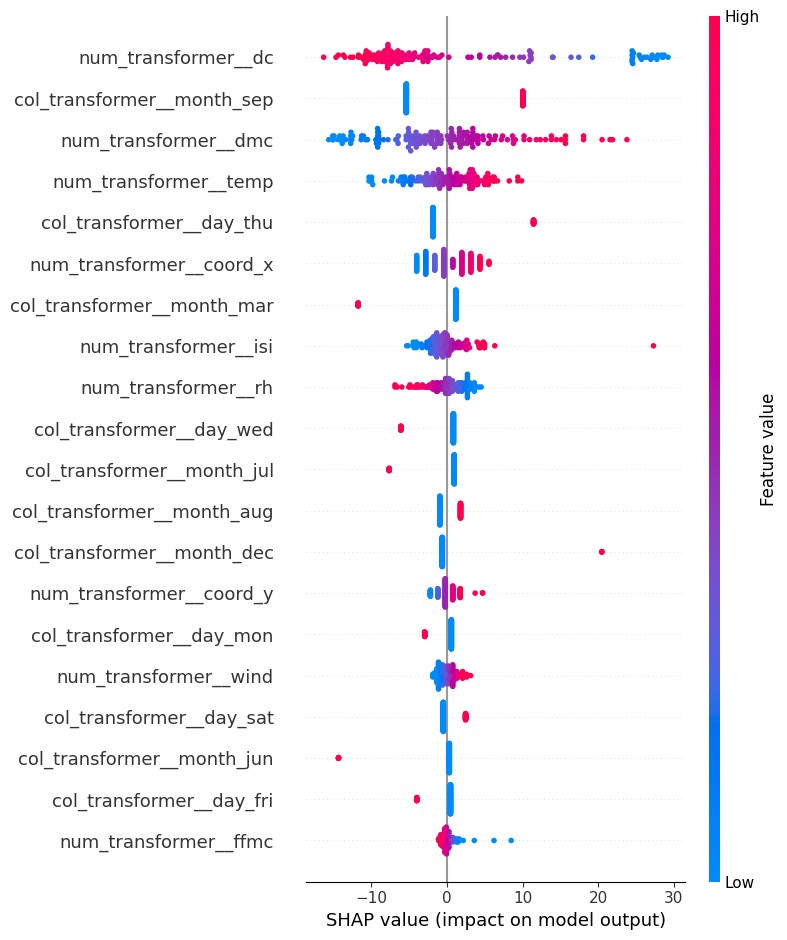

In [46]:

pipeline_A.fit(X_train,y_train)
x_a = pipeline_A['preproc'].transform(X_test)
explainer = shap.Explainer(pipeline_A['regressor'], x_a)
shap_values = explainer(x_a)
shap.summary_plot(shap_values, x_a, feature_names=pipeline_A['preproc'].get_feature_names_out())

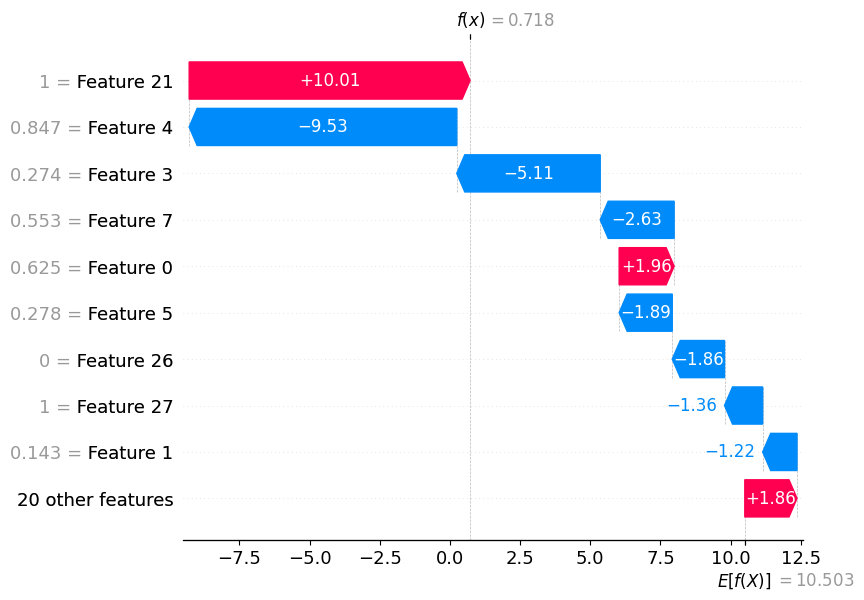

In [47]:
shap.plots.waterfall(shap_values[0])

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.